In [1]:
# 自动计算cell的计算时间
%load_ext autotime

%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 9.12 ms (started: 2021-08-11 14:27:48 +08:00)


In [7]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch2 #4 change Aug 11, 2021'

git push origin master

origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (fetch)
origin	git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git (push)
[master bd772a5] 更新 ch2 #4 change Aug 11, 2021
 2 files changed, 2930 insertions(+), 78 deletions(-)
 create mode 100644 ch3.ipynb


To git@github.com:ustchope/Advanced-Deep-Learning-with-Keras.git
   4628c81..bd772a5  master -> master


time: 5.96 s (started: 2021-08-11 14:59:27 +08:00)


In [2]:
# 设置多GPU并行
import tensorflow as tf

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')
Number of devices: 8
time: 15.8 s (started: 2021-08-11 14:28:21 +08:00)


In [2]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

time: 3.58 s (started: 2021-08-11 11:50:18 +08:00)


# 深度神经网络

在本章中，我们将研究深度神经网络。 这些网络在 ImageNet、CIFAR10 (https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) 等更具挑战性的数据集上的分类准确性方面表现出色 CIFAR100。 为简洁起见，我们将只关注两个网络：ResNet 和 DenseNet。 虽然我们将详细介绍，但花点时间介绍这些网络很重要。

ResNet 引入了残差学习的概念，这使它能够通过解决深度卷积网络中的梯度消失问题（在第 2 节中讨论）来构建非常深的网络。
DenseNet 通过允许每个卷积直接访问输入和较低层的特征图，进一步改进了 ResNet。 通过利用瓶颈层和过渡层，它还设法将深度网络中的参数数量保持在较低水平。

但为什么是这两个模型，而不是其他模型？ 嗯，自从它们被引入以来，已经有无数模型，例如 ResNeXt [6] 和 WideResNet，它们受到这两个网络使用的技术的启发。 同样，通过对 ResNet 和 DenseNet 的理解，我们将能够使用他们的设计指南来构建我们自己的模型。 通过使用迁移学习，这也将使我们能够将预训练的 ResNet 和 DenseNet 模型用于我们自己的目的，例如对象检测和分割。 仅这些原因，再加上它们与 Keras 的兼容性，就使这两个模型成为探索和补充本书高级深度学习范围的理想选择。

虽然本章的重点是深度神经网络； 我们将通过讨论 Keras 的一个重要特性（称为函数式 API）来开始本章。 此 API 充当在 tf.keras 中构建网络的替代方法，使我们能够构建序列模型 API 无法完成的更复杂的网络。 我们如此关注这个 API 的原因是它将成为构建深度网络的一个非常有用的工具，比如我们在本章中关注的两个。 建议您在进入本章之前完成第 1 章，介绍使用 Keras 进行高级深度学习，因为我们将参考该章节中探索的介绍级代码和概念，以便在本章中将它们带到高级级别。

本章的目标是介绍：
* Keras 中的函数式 API，以及探索运行它的网络示例
* tf.keras 中的深度残差网络（ResNet 版本 1 和 2）实现
* 密集连接卷积网络 (DenseNet) 在 tf.keras 中的实现
* 探索两种流行的深度学习模型，ResNet 和 DenseNet

让我们从讨论函数式 API 开始。

## 函数式API

在我们在第 1 章介绍使用 Keras 的高级深度学习中首次介绍的序列模型 API 中，一层堆叠在另一层之上。 通常，模型将通过其输入和输出层访问。 我们还了解到，如果我们发现自己想要在网络中间添加一个辅助输入，甚至在最后一层之前提取一个辅助输出，则没有简单的机制。

该模型也有其缺点。 例如，它不支持类似图形的模型或行为类似于 Python 函数的模型。 此外，在两个模型之间共享层也很困难。 Functional API 解决了这些限制，这也是为什么它是任何想要使用深度学习模型的人的重要工具的原因。

Functional API 由以下两个概念指导：
* 层是一个接受张量作为参数的实例。 一层的输出是另一个张量。 为了构建模型，层实例是通过输入和输出张量相互链接的对象。 这将产生与在 Sequential 模型中堆叠多个层类似的最终结果。 但是，使用层实例使模型更容易拥有辅助或多个输入和输出，因为每个层的输入/输出都可以轻松访问。
* 模型是一个或多个输入张量和输出张量之间的函数。 在模型输入和输出之间，张量是通过层输入和输出张量相互链接的层实例。 因此，模型是一个或多个输入层和一个或多个输出层的函数。 模型实例将关于数据如何从输入流向输出的计算图形式化。

完成 Functional API 模型的构建后，训练和评估将由 Sequential 模型中使用的相同函数执行。 为了说明，在函数式 API 中，一个二维卷积层 Conv2D，具有 32 个过滤器，x 作为层输入张量，y 作为层输出张量，可以写成：

In [ ]:
y = Conv2D(32)(x)

我们还能够堆叠多个层来构建我们的模型。 例如，我们可以使用功能 API 在 MNIST cnn-mnist-1.4.1.py 上重写卷积神经网络 (CNN)，如下面的清单所示：

> 清单 2.1.1：cnn-functional-2.1.1.py

In [5]:
''' Using Functional API to build CNN

~99.3% test accuracy
'''

import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical


# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(inputs)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           activation='relu')(y)
# image to vector before connecting to dense layer
y = Flatten()(y)
# dropout regularization
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)
# network model in text
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

In [6]:
# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=20,
          batch_size=batch_size)

Epoch 1/20
469/469 [==============================] - 17s 19ms/step - loss: 0.2612 - accuracy: 0.9211 - val_loss: 0.0539 - val_accuracy: 0.9834
Epoch 2/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0697 - accuracy: 0.9785 - val_loss: 0.0358 - val_accuracy: 0.9886
Epoch 3/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0500 - accuracy: 0.9841 - val_loss: 0.0283 - val_accuracy: 0.9904
Epoch 4/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0398 - accuracy: 0.9876 - val_loss: 0.0325 - val_accuracy: 0.9894
Epoch 5/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0346 - accuracy: 0.9888 - val_loss: 0.0270 - val_accuracy: 0.9916
Epoch 6/20
469/469 [==============================] - 7s 14ms/step - loss: 0.0286 - accuracy: 0.9906 - val_loss: 0.0287 - val_accuracy: 0.9902
Epoch 7/20
469/469 [==============================] - 7s 15ms/step - loss: 0.0272 - accuracy: 0.9911 - val_loss: 0.0249 - val_accuracy: 0.991

time: 2min 28s (started: 2021-08-11 11:14:52 +08:00)


In [7]:
# model accuracy on test dataset
score = model.evaluate(x_test,
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 99.3%
time: 895 ms (started: 2021-08-11 11:18:16 +08:00)


默认情况下，MaxPooling2D 使用 pool_size=2，因此该参数已被删除。

在前面的清单中，每一层都是张量的函数。 每层生成一个张量作为输出，该张量成为下一层的输入。 为了创建这个模型，我们可以调用 Model() 并提供输入和输出张量，或者张量列表。 其他一切都保持不变。

同样的列表也可以使用 fit() 和 evaluate() 函数进行训练和评估，类似于 Sequential 模型。 Sequential 类实际上是 Model 类的子类。 我们需要记住，我们在 fit() 函数中插入了 validation_data 参数，以查看训练期间验证准确性的进展。 准确率在 20 个 epoch 中从 99.3% 到 99.4% 不等。

### 创建二输入一输出模型

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcaqlbq7oj30yg0pmmzi.jpg)我们现在要做一些非常令人兴奋的事情，创建一个具有两个输入和一个输出的高级模型。 在我们开始之前，重要的是要知道 Sequential 模型 API 仅用于构建 1-input 和 1-output 模型。

假设发明了一种用于 MNIST 数字分类的新模型，称为 Y 网络，如图 2.1.1 所示。 Y-Network 在左右 CNN 分支上使用相同的输入两次。 网络使用连接层组合结果。 合并操作 concatenate 类似于将两个形状相同的张量沿串联轴堆叠以形成一个张量。 例如，沿最后一个轴连接两个形状为 (3, 3, 16) 的张量将产生形状为 (3, 3, 32) 的张量。

连接层之后的其他所有内容都将与前一章的 CNN MNIST 分类器模型相同：Flatten，然后是 Dropout，然后是 Dense：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcaqlbq7oj30yg0pmmzi.jpg)

为了提高代码清单 2.1.1 中模型的性能，我们可以提出几个变化。首先，Y-Network 的分支将过滤器的数量加倍，以补偿 MaxPooling2D() 之后特征图大小的减半。例如，如果第一个卷积的输出是 (28, 28, 32)，则最大池化后的新形状是 (14, 14, 32)。下一个卷积的过滤器大小为 64，输出维度为 (14, 14, 64)。

其次，尽管两个分支的内核大小相同，均为 3，但右分支使用的扩张率为 2。图 2.1.2 显示了不同扩张率对大小为 3 的内核的影响。使用膨胀率确定内核的字段大小，CNN 将启用正确的分支来学习不同的特征图。使用大于 1 的扩张率是一种在计算上有效的近似方法来增加感受野大小。它是近似的，因为内核实际上并不是一个成熟的内核。它是有效的，因为我们使用的操作次数与膨胀率等于 1 的次数相同。

要理解感受野的概念，请注意，当内核计算特征图的每个点时，它的输入是前一层特征图中的一个补丁，它也依赖于其前一层特征图。 如果我们继续跟踪这种依赖到输入图像，内核依赖于称为感受野的图像块。

我们将使用选项 padding='same' 来确保在使用扩张的 CNN 时我们不会有负张量维度。 通过使用 padding='same'，我们将保持输入的维度与输出特征图的维度相同。 这是通过用零填充输入以确保输出具有相同大小来实现的。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcaucsq2cj31ds0ioq4t.jpg)

cnn-y-network-2.1.2.py 的清单 2.1.2 显示了使用功能 API 实现 Y-Network。 这两个分支由两个 for 循环创建。 两个分支都期望相同的输入形状。 这两个 for 循环将创建两个 3 层的 Conv2D-Dropout-MaxPooling2D 堆栈。 虽然我们使用连接层来组合左右分支的输出，但我们也可以利用 tf.keras 的其他合并功能，例如加、点和乘。 合并函数的选择并非完全随意，而是必须基于合理的模型设计决策。

在 Y-Network 中，concatenate 不会丢弃特征图的任何部分。 相反，我们将让 Dense 层弄清楚如何处理连接的特征图。

> 清单 2.1.2：cnn-y-network-2.1.2.py

In [8]:
'''Implements a Y-Network using Functional API

~99.3% test accuracy
'''


import numpy as np

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# from sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# reshape and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
dropout = 0.4
n_filters = 32

# left branch of Y network
left_inputs = Input(shape=input_shape)
x = left_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu')(x)
    x = Dropout(dropout)(x)
    x = MaxPooling2D()(x)
    filters *= 2

# right branch of Y network
right_inputs = Input(shape=input_shape)
y = right_inputs
filters = n_filters
# 3 layers of Conv2D-Dropout-MaxPooling2D
# number of filters doubles after each layer (32-64-128)
for i in range(3):
    y = Conv2D(filters=filters,
               kernel_size=kernel_size,
               padding='same',
               activation='relu',
               dilation_rate=2)(y)
    y = Dropout(dropout)(y)
    y = MaxPooling2D()(y)
    filters *= 2

# merge left and right branches outputs
y = concatenate([x, y])
# feature maps to vector before connecting to Dense 
y = Flatten()(y)
y = Dropout(dropout)(y)
outputs = Dense(num_labels, activation='softmax')(y)

# build the model in functional API
model = Model([left_inputs, right_inputs], outputs)

# verify the model using graph
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file='cnn-y-network.png', show_shapes=True)

# verify the model using layer text description
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 28, 28, 32)   320         input_3[0][0]                    
____________________________________________________________________________________________

In [9]:
# classifier loss, Adam optimizer, classifier accuracy
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# train the model with input images and labels
model.fit([x_train, x_train],
          y_train, 
          validation_data=([x_test, x_test], y_test),
          epochs=20,
          batch_size=batch_size)

Epoch 1/20
1875/1875 [==============================] - 26s 12ms/step - loss: 0.1775 - accuracy: 0.9458 - val_loss: 0.1641 - val_accuracy: 0.9854
Epoch 2/20
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0664 - accuracy: 0.9796 - val_loss: 0.0945 - val_accuracy: 0.9892
Epoch 3/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0534 - accuracy: 0.9831 - val_loss: 0.0721 - val_accuracy: 0.9921
Epoch 4/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0465 - accuracy: 0.9855 - val_loss: 0.0761 - val_accuracy: 0.9912
Epoch 5/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0424 - accuracy: 0.9871 - val_loss: 0.0478 - val_accuracy: 0.9936
Epoch 6/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 0.0386 - val_accuracy: 0.9926
Epoch 7/20
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0378 - accuracy: 0.9879 - val_loss: 0.0426 -

time: 7min 20s (started: 2021-08-11 11:28:49 +08:00)


In [10]:
# model accuracy on test dataset
score = model.evaluate([x_test, x_test],
                       y_test,
                       batch_size=batch_size,
                       verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))


Test accuracy: 99.2%
time: 3.88 s (started: 2021-08-11 11:36:09 +08:00)


退一步，我们可以注意到 Y-Network 需要两个输入用于训练和验证。 输入是相同的，因此提供了 [x_train, x_train]。

在 20 个 epoch 的过程中，Y-Network 的准确率从 99.4% 到 99.5% 不等。 这比 3-stack CNN 略有改进，后者实现了 99.3% 到 99.4% 的准确率。 然而，这是以更高的成本为代价的
复杂性和参数数量的两倍以上。

下图，图 2.1.3，显示了 Keras 理解的并由 plot_model() 函数生成的 Y 网络架构：

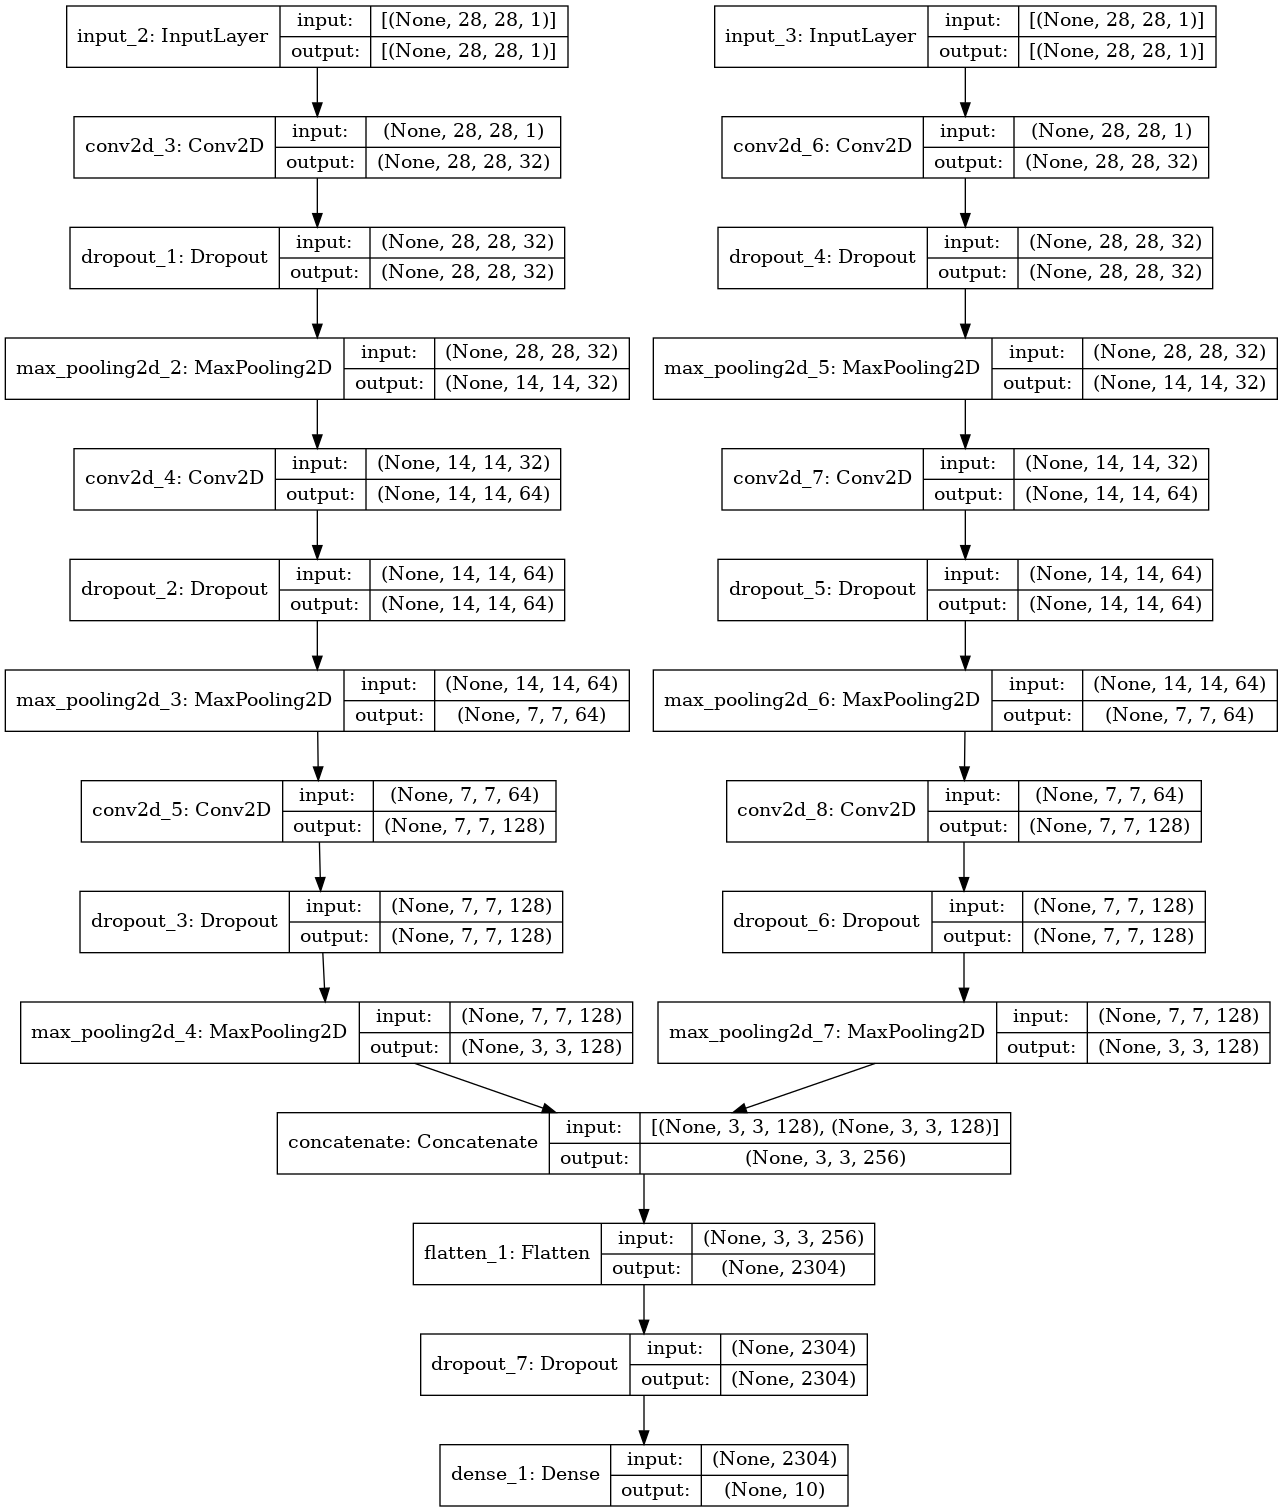

time: 607 ms (started: 2021-08-11 11:36:51 +08:00)


In [12]:
 plot_model(model, show_shapes=True)

我们对 Functional API 的研究到此结束。 我们应该花时间记住本章的重点是构建深度神经网络，特别是 ResNet 和 DenseNet。 因此，我们只涵盖构建它们所需的函数式 API 材料，因为涵盖整个 API 超出了本书的范围。 话虽如此，让我们继续讨论 ResNet。

## 深度残差网络 (ResNet)

深度网络的一个关键优势是它们具有从输入和特征图学习不同级别表示的强大能力。在分类、分割、检测和许多其他计算机视觉问题中，学习不同的特征图通常会带来更好的性能。

但是，您会发现训练深度网络并不容易，因为在反向传播期间梯度可能会随着浅层深度的增加而消失（或爆炸）。图 2.2.1 说明了梯度消失的问题。网络参数通过从输出层到所有先前层的反向传播进行更新。由于反向传播基于链式法则，梯度到达浅层时有减小的趋势。这是由于小数的乘法，特别是对于小损失函数和参数值。

乘法运算的次数将与网络的深度成正比。还值得注意的是，如果梯度下降，参数将不会适当更新。

因此，网络将无法提高其性能。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcb4q749oj30x20l80tt.jpg)

为了缓解深度网络中梯度的退化，ResNet 引入了深度残差学习框架的概念。 让我们分析一个区块：我们深层网络的一小部分。

图 2.2.2 显示了典型 CNN 块和 ResNet 残差块之间的比较。 ResNet 的思想是为了防止梯度下降，我们让信息通过快捷连接到达浅层。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcb68succj318o0gywg3.jpg)

接下来，我们将在讨论两个块之间的差异时查看更多细节。 图 2.2.3 显示了另一个常用深度网络 VGG [3] 和 ResNet 的 CNN 块的更多细节。 我们将层特征图表示为 $x$。 第 $l$ 层的特征图是 $x_l$。 CNN层中的操作是`Conv2D-Batch Normalization(BN)-ReLU`。

假设我们以 H() = Conv2D-Batch Normalization(BN)-ReLU 的形式表示这组操作； 然后：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcb9ubxrcj315y04yjrj.jpg)

换句话说，第l-2层的特征图被转换为$x_{l-1}$ 通过 H() = Conv2D-批量归一化(BN)-ReLU。 应用相同的一组操作将 $x_{l-1}$ 转换为 $x_l$。 换句话说，如果我们有一个 18 层的 VGG，那么在输入图像被转换为第 18 层特征图之前有 18 次 H() 操作。

一般而言，我们可以观察到第 l 层输出的特征图仅直接受先前特征图的影响。 同时，对于 ResNet：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcbc80j94j316e04saaa.jpg)

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcbchd3pwj31900muwg3.jpg)

$F(x_{l-1})$ 由 `Conv2D-BN` 构成，也称为残差映射。 `+` 符号是快捷连接和 $F(x_{l-1})$ 的输出之间的张量元素相加。 快捷连接不会添加额外的参数，也不会增加额外的计算复杂度。

添加操作可以在 `tf.keras` 中通过 `add()` 合并函数来实现。 但是，$F(x_{l-1})$ 和 $x_{l-2}$ 应该具有相同的尺寸。

如果维度不同，例如在改变特征图大小时，我们应该在 $x_{l-2}$ 上执行线性投影以匹配 $F(x_{l-1})$ 的大小。 在原始论文中，当特征图大小减半时，这种情况的线性投影是由具有 `1 × 1` 内核和stride = 2 的 `Conv2D` 完成的。

回到第 1 章，介绍使用 Keras 进行高级深度学习，我们讨论了 stride > 1 相当于在卷积过程中跳过像素。 例如，如果strides=2，我们可以在卷积过程中滑动内核时每隔一个像素跳过一次。

前面的公式 2.2.3 和公式 2.2.4 都对 ResNet 残差块操作建模。 它们意味着如果可以训练更深层的误差更少，那么浅层就没有理由应该有更高的误差。

了解了 ResNet 的基本构建块，我们就能够设计一个用于图像分类的深度残差网络。 然而，这一次，我们将处理更具挑战性的数据集。

在我们的示例中，我们将考虑 CIFAR10，它是原始论文经过验证的数据集之一。 在这个例子中，tf.keras 提供了一个 API 来方便地访问 CIFAR10 数据集，如图：

In [4]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 667s 4us/step
time: 11min 11s (started: 2021-08-11 12:32:13 +08:00)


和 MNIST 一样，CIFAR10 数据集有 10 个类别。 该数据集是飞机、汽车、鸟、猫、鹿、狗、青蛙、马、船和卡车的小型 (32 × 32) RGB 真实世界图像的集合，对应于 10个类别中的每一个。 图 2.2.4 显示了来自 CIFAR10 的示例图像。

在数据集中，有 50,000 张标记的训练图像和 10,000 张标记的测试图像用于验证：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcqpucdbwj618k0tqjyl02.jpg)

对于 CIFAR10 数据，可以使用不同的网络架构构建 ResNet，如表 2.2.1 所示。 表 2.2.1 意味着我们有三组残差块。 每个集合有 2n 个层，对应于 n 个残差块。 32 × 32 中的额外层是输入图像的第一层。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcqqvia7cj60pi0pcdhv02.jpg)

内核大小为3，除了两个不同大小的特征图之间的过渡，实现了线性映射。 例如，内核大小为 1 且步幅 = 2 的 Conv2D。 为了与 DenseNet 保持一致，当我们连接两个不同大小的残差块时，我们将使用术语转换层。

ResNet 使用 kernel_initializer='he_normal' 以在发生反向传播时帮助收敛 [1]。 最后一层由AveragePooling2D-Flatten-Dense组成。 此时值得注意的是，ResNet 不使用 dropout。 似乎加合并操作和 1 x 1 卷积具有自正则化效果。 图 2.2.5 显示了表 2.2.1 中描述的 CIFAR10 数据集的 ResNet 模型架构。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcr1ii96wj61b00kywga02.jpg)

以下代码片段显示了 tf.keras 中的部分 ResNet 实现。 代码已贡献给 Keras GitHub 存储库。 从表 2.2.2（稍后显示）我们还可以看到，通过修改 n 的值，我们能够增加网络的深度。

例如，对于 n = 18，我们已经有了 ResNet110，一个具有 110 层的深度网络。 为了构建 ResNet20，我们使用 n = 3：

In [ ]:
n = 3
# model version
# orig paper: version = 1 (ResNet v1),
# improved ResNet: version = 2 (ResNet v2)
version = 1
# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

resnet_v1() 方法是 ResNet 的模型构建器。 它使用实用函数 resnet_layer() 来帮助构建 Conv2D-BN-ReLU 的堆栈。

它被称为版本 1，正如我们将在下一节中看到的，提出了改进的 ResNet，称为 ResNet 版本 2 或 v2。 在 ResNet 上，ResNet v2 具有改进的残差块设计，从而获得更好的性能。

下面的清单显示了 resnet-cifar10-2.2.1.py 的部分代码，它是 ResNet v1 的 tf.keras 模型实现。

In [6]:
"""Trains a ResNet on the CIFAR10 dataset.

ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf

ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1

# computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    Arguments:
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    Returns:
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved
    (downsampled) by a convolutional layer with strides=2, while 
    the number of filters is doubled. Within each stage, 
    the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    # start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or 
    also known as bottleneck layer.
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, 
    the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, 
    while the number of filter maps is
    doubled. Within each stage, the layers have 
    the same number filters and the same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    Arguments:
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    Returns:
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 110 in [b])')
    # start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU
    # on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                # first layer and first stage
                if res_block == 0:  
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                # first layer but not first stage
                if res_block == 0:
                    # downsample
                    strides = 2 

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection
                # to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])

        num_filters_in = num_filters_out

    # add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['acc'])
model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch

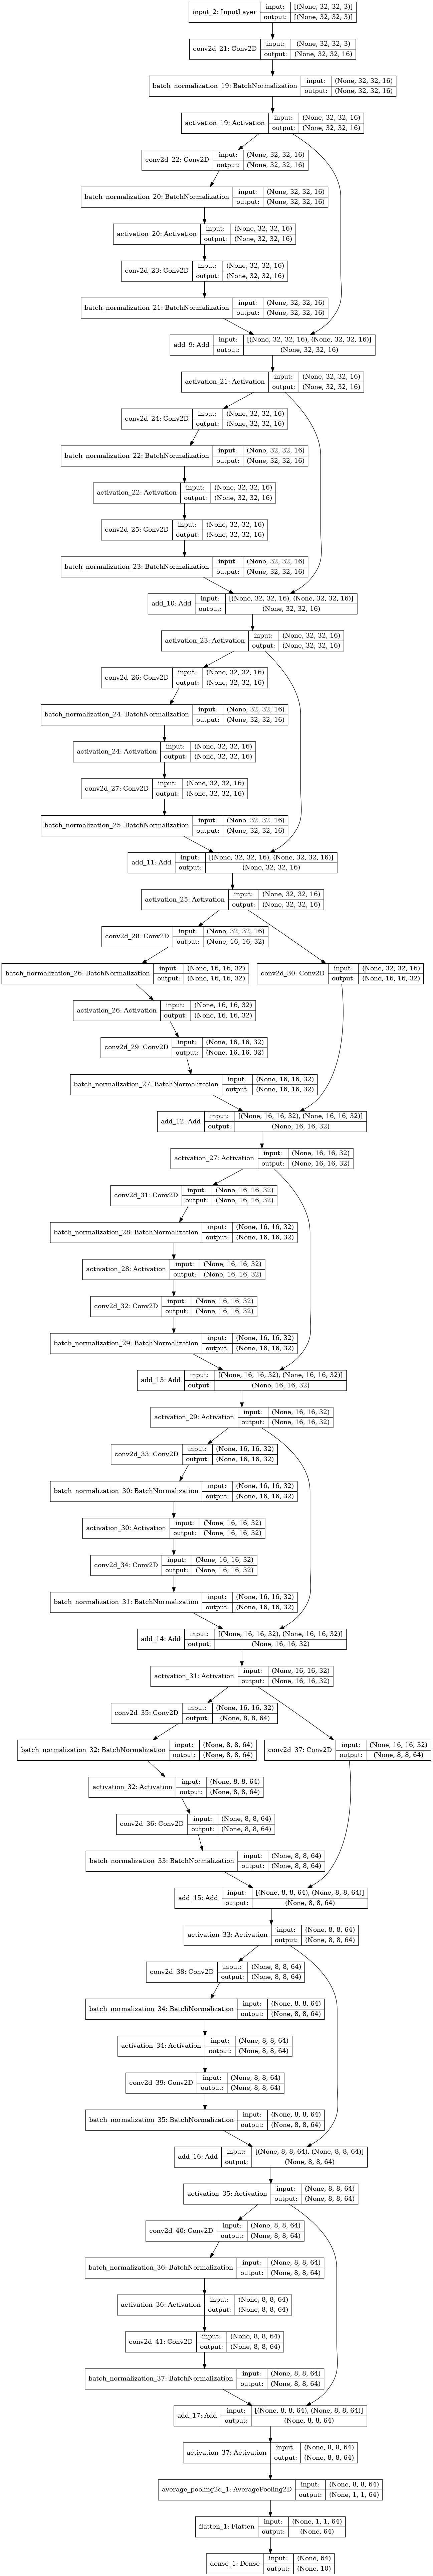

time: 1.14 s (started: 2021-08-11 12:54:22 +08:00)


In [9]:
# enable this if pydot can be installed
# pip install pydot
plot_model(model, show_shapes=True)
#print(model_type)

In [ ]:
# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # this will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False)

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    steps_per_epoch =  math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
1563/1563 [==============================] - 73s 40ms/step - loss: 1.5640 - acc: 0.4963 - val_loss: 1.6549 - val_acc: 0.5315

Epoch 00001: val_acc improved from -inf to 0.53150, saving model to /public/huangwei/node34/tutorial/Advanced-Deep-Learning-with-Keras/saved_models/cifar10_ResNet20v1_model.001.h5


/public/huangwei/miniconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/200
Learning rate:  0.001
1563/1563 [==============================] - 59s 38ms/step - loss: 1.1659 - acc: 0.6427 - val_loss: 1.0485 - val_acc: 0.6896

Epoch 00002: val_acc improved from 0.53150 to 0.68960, saving model to /public/huangwei/node34/tutorial/Advanced-Deep-Learning-with-Keras/saved_models/cifar10_ResNet20v1_model.002.h5
Epoch 3/200
Learning rate:  0.001
1563/1563 [==============================] - 59s 38ms/step - loss: 1.0092 - acc: 0.7031 - val_loss: 1.0420 - val_acc: 0.6911

Epoch 00003: val_acc improved from 0.68960 to 0.69110, saving model to /public/huangwei/node34/tutorial/Advanced-Deep-Learning-with-Keras/saved_models/cifar10_ResNet20v1_model.003.h5
Epoch 4/200
Learning rate:  0.001
1563/1563 [==============================] - 59s 38ms/step - loss: 0.9226 - acc: 0.7349 - val_loss: 0.8889 - val_acc: 0.7492

Epoch 00004: val_acc improved from 0.69110 to 0.74920, saving model to /public/huangwei/node34/tutorial/Advanced-Deep-Learning-with-Keras/saved_models/cif

In [ ]:
# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

ResNet 在各种 n 值上的性能如表 2.2.2 所示。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcrlsxiuoj618u0eywgy02.jpg)

与 ResNet 的原始实现有一些细微差别。 特别是，我们不使用 SGD，而是使用 Adam。 这是因为 ResNet 更容易与 Adam 收敛。 我们还将使用学习率 (lr) 调度程序 lr_schedule()，以便从默认 1e-3 的 80、120、160 和 180 个时期安排 lr 的减少。 lr_schedule() 函数将在训练期间的每个 epoch 之后作为回调变量的一部分被调用。

每次验证准确性取得进展时，另一个回调都会保存检查点。 在训练深度网络时，保存模型或权重检查点是一个很好的做法。 这是因为训练深度网络需要大量时间。

当您想使用您的网络时，您只需重新加载检查点，并恢复训练好的模型。 这可以通过调用 tf.keras load_model() 来完成。 包括 lr_reducer() 函数。 如果指标在计划减少之前达到稳定状态，如果在patience = 5 个时期后验证损失没有改善，则此回调将根据参数中提供的某个因素降低学习率。

callbacks 变量在调用 model.fit() 方法时提供。 与原始论文类似，tf.keras 实现使用数据增强 ImageDataGenerator()，以便提供额外的训练数据作为正则化方案的一部分。 随着训练数据数量的增加，泛化能力会提高。

例如，一个简单的数据增强是翻转狗的照片，如图 2.2.6 所示（horizontal_flip = True）。 如果是狗的图像，那么翻转后的图像仍然是狗的图像。 还可以进行其他变换，如缩放、旋转、白化等，标签仍保持不变：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcsc35khsj61aq0kumzr02.jpg)

完整代码可在 GitHub 上获得：https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras。

通常很难完全复制原始论文的实现。 在本书中，我们使用了不同的优化器和数据增强。 这可能会导致本书中实现的 tf.keras ResNet 的性能与原始论文中的模型略有不同。

在 ResNet [4] 上的第二篇论文发布后，本节中介绍的原始模型被称为 ResNet v1。 改进后的 ResNet 通常称为 ResNet v2，我们将在下一节中讨论。

## ResNet v2

ResNet v2 的改进主要体现在残差块中的层排列，如图 2.3.1 所示。
ResNet v2 的显着变化是：
* 1 x 1 – 3 x 3 – 1 × 1 BN-ReLU-Conv2D 堆栈的使用
* 批量归一化和 ReLU 激活出现在二维卷积之前

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcsgonrocj61ai0nk76d02.jpg)

ResNet v2 也在与 resnet-cifar10-2.2.1.py 相同的代码中实现，如清单 2.2.1 所示：

ResNet v2 的准确率如下表 2.3.1 所示：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcsjlvlzij6188096q4f02.jpg)

在 Keras 应用程序包中，已经实现了某些 ResNet v1 和 v2 模型（例如：50、101、152）。 这些是预训练权重不明确的替代实现，可以很容易地重用于迁移学习。 本书中使用的模型在层数方面提供了灵活性。

我们已经完成了对最常用的深度神经网络之一 ResNet v1 和 v2 的讨论。 在下一节中，将介绍另一种流行的深度神经网络架构 DenseNet。

## 密集连接的卷积网络 (DenseNet)

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcsl5w41fj61am0jmq5602.jpg)

DenseNet 使用不同的方法解决梯度消失的问题。 之前的所有特征图将成为下一层的输入，而不是使用快捷连接。 上图显示了一个 Dense 块中的 Dense 互连示例。

为简单起见，在此图中，我们将仅显示四层。 请注意，第 l 层的输入是所有先前特征图的串联。 如果我们让 BN-ReLU-Conv2D 由操作 H(x) 表示，那么第 l 层的输出为：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcspwc5rdj61g203maa702.jpg)

Conv2D 使用大小为 3 的内核。每层生成的特征图的数量称为增长率，k。 通常，k = 12，但在 Huang 等人的论文 Densely Connected Convolutional Networks 中也使用了 k = 24。 (2017) [5]。 因此，如果特征图 $x_0$ 的数量为 $k_0$，那么图 2.4.1 中 4 层 Dense 块末尾的特征图总数将为 $4 \times k + k_0$。

DenseNet 建议在 Dense 块之前是 BN-ReLU-Conv2D，以及一些两倍增长率的特征图，k0 = 2 x k。 在 Dense 块的末尾，特征图的总数将为 4 x 12 + 2 x 12 = 72。

在输出层，DenseNet 建议我们在 Dense() 之前使用 softmax 层执行平均池化。 如果不使用数据增强，Dense 块 Conv2D 之后必须有一个 dropout 层。

随着网络越来越深，会出现两个新问题。 首先，由于每层贡献 k 个特征图，第 l 层的输入数量为 $(l – 1) \times k + k_0$。 特征图可以在深层内快速增长，从而减慢计算速度。 例如，对于 101 层网络，对于 k = 12，这将是 1200 + 2_4 = 1224。

其次，与 ResNet 类似，随着网络变得更深，特征图大小将减小以增加内核的感受野大小。 如果 DenseNet 在合并操作中使用串联，它必须协调大小的差异。

为了防止特征图的数量增加到计算效率低下的程度，DenseNet 引入了瓶颈层，如图 2.4.2 所示。 这个想法是在每次连接之后，现在应用一个过滤器大小等于 4k 的 1 x 1 卷积。 这种降维技术可以防止 Conv2D(3) 处理的特征图数量快速增加。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtcsx1lu7mj61ia0juq5k02.jpg)

瓶颈层然后将 DenseNet 层修改为 BN-ReLU-Conv2D(1)-BN-ReLU-Conv2D(3)，而不仅仅是 BN-ReLU-Conv2D(3)。 为清楚起见，我们已将内核大小作为 Conv2D 的参数。 使用 Bottleneck 层，每个 Conv2D(3) 只处理 4k 个特征图，而不是第 l 层的 (l – 1) x k + k0。 例如，对于 101 层网络，最后一个 Conv2D(3) 的输入仍然是 k = 12 时的 48 个特征图，而不是之前计算的 1224 个。

为了解决特征图大小不匹配的问题，DenseNet 将一个深度网络划分为多个 Dense 块，这些块通过过渡层连接在一起，如图 2.4.3 所示。 在每个 Dense 块内，特征图的大小（即宽度和高度）将保持不变。

过渡层的作用是在两个 Dense 块之间从一个特征图尺寸过渡到更小的特征图尺寸。 尺寸的减少通常是一半。 这是由平均池化层完成的。 例如，默认 pool_size=2 的 AveragePooling2D 将大小从 (64, 64, 256) 减小到 (32, 32, 256)。 过渡层的输入是前一个 Dense 块中最后一个连接层的输出。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtct1l7q1pj61ja0ngac502.jpg)

然而，在特征图被传递到平均池化之前，它们的数量会减少一定的压缩因子，0 < 𝜃 < 1，使用 Conv2D(1)。 DenseNet 在他们的实验中使用 𝜃 = 0.5。 例如，如果前一个 Dense 块的最后一个串联的输出是 (64, 64, 512)，那么在 Conv2D(1) 之后，特征图的新维度将是 (64, 64, 256)。 当压缩和降维放在一起时，过渡层由 BN Conv2D(1)-AveragePooling2D 层组成。 实际上，批量归一化在卷积层之前。

我们现在已经介绍了 DenseNet 的重要概念。 接下来，我们将为 tf.keras 中的 CIFAR10 数据集构建和验证 DenseNet-BC。

### 为 CIFAR10 构建 100 层 DenseNet-BC

我们现在将使用我们上面讨论的设计原则为 CIFAR10 数据集构建一个具有 100 层的 DenseNet-BC（瓶颈压缩）。

模型配置如表 2.4.1 所示，模型架构如图 2.4.4 所示。 该清单向我们展示了具有 100 层的 DenseNet-BC 的部分 Keras 实现。 我们需要注意我们使用 RMSprop，因为它在使用 DenseNet 时比 SGD 或 Adam 收敛得更好。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtct5hj9omj60qi0iaacd02.jpg)

从配置转向架构：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gtctpvjbjwj60u60n4jso02.jpg)

下面的清单 2.4.1 是具有 100 层的 DenseNet-BC 的部分 Keras 实现，如表 2.4.1 所示。

> 清单 2.4.1：densenet-cifar10-2.4.1.py

In [5]:
"""Trains a 100-Layer DenseNet on the CIFAR10 dataset.

With data augmentation:
Greater than 93.55% test accuracy in 200 epochs
225sec per epoch on GTX 1080Ti

Densely Connected Convolutional Networks
https://arxiv.org/pdf/1608.06993.pdf
http://openaccess.thecvf.com/content_cvpr_2017/papers/
    Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
Network below is similar to 100-Layer DenseNet-BC (k=12)
"""

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Flatten, Dropout
from tensorflow.keras.layers import concatenate, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import os
import numpy as np
import math

# training parameters
batch_size = 32
epochs = 200
data_augmentation = True

# network parameters
num_classes = 10
num_dense_blocks = 3
use_max_pool = False

# DenseNet-BC with dataset augmentation
# Growth rate   | Depth |  Accuracy (paper)| Accuracy (this)      |
# 12            | 100   |  95.49%          | 93.74%               |
# 24            | 250   |  96.38%          | requires big mem GPU |
# 40            | 190   |  96.54%          | requires big mem GPU |
growth_rate = 12
depth = 100
num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

num_filters_bef_dense_block = 2 * growth_rate
compression_factor = 0.5

# load the CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions
input_shape = x_train.shape[1:]

# mormalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def get_model():
    growth_rate = 12
    depth = 100
    num_bottleneck_layers = (depth - 4) // (2 * num_dense_blocks)

    num_filters_bef_dense_block = 2 * growth_rate
    compression_factor = 0.5
    
    # start model definition
    # densenet CNNs (composite function) are made of BN-ReLU-Conv2D
    inputs = Input(shape=input_shape)
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(num_filters_bef_dense_block,
               kernel_size=3,
               padding='same',
               kernel_initializer='he_normal')(x)
    x = concatenate([inputs, x])

    # stack of dense blocks bridged by transition layers
    for i in range(num_dense_blocks):
        # a dense block is a stack of bottleneck layers
        for j in range(num_bottleneck_layers):
            y = BatchNormalization()(x)
            y = Activation('relu')(y)
            y = Conv2D(4 * growth_rate,
                       kernel_size=1,
                       padding='same',
                       kernel_initializer='he_normal')(y)
            if not data_augmentation:
                y = Dropout(0.2)(y)
            y = BatchNormalization()(y)
            y = Activation('relu')(y)
            y = Conv2D(growth_rate,
                       kernel_size=3,
                       padding='same',
                       kernel_initializer='he_normal')(y)
            if not data_augmentation:
                y = Dropout(0.2)(y)
            x = concatenate([x, y])

        # no transition layer after the last dense block
        if i == num_dense_blocks - 1:
            continue

        # transition layer compresses num of feature maps and reduces the size by 2
        num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
        num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor)
        y = BatchNormalization()(x)
        y = Conv2D(num_filters_bef_dense_block,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal')(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = AveragePooling2D()(y)


    # add classifier on top
    # after average pooling, size of feature map is 1 x 1
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    kernel_initializer='he_normal',
                    activation='softmax')(y)

    # instantiate and compile model
    # orig paper uses SGD but RMSprop works better for DenseNet
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(1e-3),
                  metrics=['acc'])
    
    return model

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_model()
    
model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/dev

In [6]:
# enable this if pydot can be installed
# pip install pydot
#plot_model(model, to_file="cifar10-densenet.png", show_shapes=True)

# prepare model model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate reducer
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # preprocessing  and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (deg 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)

    steps_per_epoch = math.ceil(len(x_train) / batch_size)
    # fit the model on the batches generated by datagen.flow().
    model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),
              steps_per_epoch=steps_per_epoch,
              callbacks=callbacks)

Using real-time data augmentation.
Epoch 1/200
Learning rate:  0.001
INFO:tensorflow:batch_all_reduce: 398 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 398 all-reduces with algorithm = nccl, num_packs = 1
1563/1563 [==============================] - 1066s 477ms/step - loss: 1.6806 - acc: 0.3952 - val_loss: 1.8502 - val_acc: 0.4401

Epoch 00001: val_acc improved from -inf to 0.44010, saving model to /public/huangwei/node34/tutorial/Advanced-Deep-Learning-with-Keras/saved_models/cifar10_densenet_model.01.h5
Epoch 2/200
Learning rate:  0.001
 913/1563 [================>.............] - ETA: 4:45 - loss: 1.2451 - acc: 0.5578

KeyboardInterrupt: 

time: 24min 31s (started: 2021-08-11 14:34:40 +08:00)


In [ ]:
    # fit the model on the batches generated by datagen.flow()
    #model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
    ##                    steps_per_epoch=x_train.shape[0] // batch_size,
    #                    validation_data=(x_test, y_test),
    #                    epochs=epochs, verbose=1,
    #                    callbacks=callbacks)

# score trained model
scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

## 结论

在本章中，我们将 Functional API 作为一种使用 tf.keras 构建复杂深度神经网络模型的高级方法进行了介绍。我们还演示了如何使用 Functional API 来构建多输入单输出 Y 网络。与单个分支 CNN 网络相比，该网络实现了更好的准确性。在本书的其余部分，我们会发现函数式 API 在构建更复杂和更高级的模型时必不可少。例如，在下一章中，Functional API 将使我们能够构建模块化的编码器、解码器和自动编码器。

我们还花了大量时间探索两个重要的深度网络，ResNet 和 DenseNet。这两个网络不仅用于分类，还用于其他领域，例如分割、检测、跟踪、生成和视觉语义理解。在第 11 章，对象检测和第 12 章，语义分割中，我们将使用 ResNet 进行对象检测和分割。我们需要记住，与仅仅遵循原始实现相比，更深入地了解 ResNet 和 DenseNet 中的模型设计决策更为重要。通过这种方式，我们将能够将 ResNet 和 DenseNet 的关键概念用于我们的目的。